탐색적 데이터 분석 (Exploratory Data Analysis)를 진행하다보면, 매우 흔한 확률로 **결측치가 존재**하는 것을 볼 수 있습니다.

우리는 이런 경우 결측치를 **버릴건지(drop), 혹은 채워**주어야 합니다.

그러나, 데이터를 함부로 **drop하여 머신러닝 예측을 진행한다는 것은 꽤 risk** 하기도 합니다. 물론 결측치가 매우 적은 경우엔 그냥 drop하는 것이 맞을 수 있습니다.

하지만, 결측치가 꽤 많이 존재하는 경우, 혹은 우리가 예측해야할 test set의 feature 데이터에 존재하는 경우에는 결측치를 채워줄 수 밖에 없습니다.

결측치를 채워 줄 때 흔히 사용되는 방법은 `0` 이나 `-1`로 단순하게 채워주거나, 조금 더 발전된 방법은 `mean`이나 `median`으로 채워주는 방법입니다. 조금 더 나아간다면, 분류형 컬럼을 기준으로 `groupby`하여 `mean`이나 `median`으로 채워줄 수 있겠네요.

하지마, 시계열(Time Series) 데이터나 연속된 수치를 가지는 데이터의 경우에는 우리는 일종의 연속성있는 패턴을 발견할 수 있습니다. 이런 경우 보간(Interpolation)을 통해 **앞,뒤 값을 통하여 유추하여 좀 더 스마트하게 결측치(NaN)를 채워**줄 수 있습니다.

대부분, `Pandas`에 이런 유용한 기능이 내장되어 있는 점을 모르는 분들이 많은데, 이번 포스팅에서는 결측치에 대하여 보간(Interpolation) 처리를 해주는 방법에 대하여 알아보도록 하겠습니다.

**참고(Reference) - Pandas 공식 도큐먼트**

[pandas.DataFrame.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

In [25]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

실습을 위하여 **Normal Distribution을 따르는 샘플을 생성**하도록 하겠습니다.

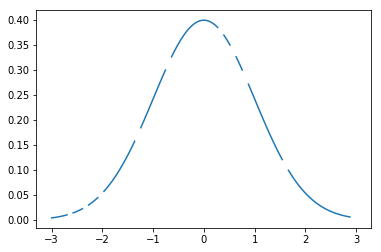

In [40]:
# 평균
mu = 0
# 분산
variance = 1
# sigma (Standard Deviation 계산)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

# 랜덤한 10개의 데이터를 삭제합니다.
idx = np.random.choice(len(x), size=10)
x[idx] = np.nan

# 시각화
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

총 10개의 NaN 값을 만들었습니다.

In [41]:
pd.Series(x).isnull().sum()

10

중간 중간에 NaN값이 포진해 있는 것을 확인할 수 있습니다.

In [42]:
pd.Series(x).head(20)

0    -3.000000
1    -2.939394
2    -2.878788
3    -2.818182
4    -2.757576
5    -2.696970
6          NaN
7    -2.575758
8    -2.515152
9    -2.454545
10   -2.393939
11         NaN
12   -2.272727
13   -2.212121
14   -2.151515
15   -2.090909
16         NaN
17   -1.969697
18   -1.909091
19   -1.848485
dtype: float64

## 보간 (Interpolation)을 활용한 결측치 대입

### 주요 Hyperparameter

**methodstr, default `linear`**
Interpolation technique 지정

-`linear`: 색인을 무시하고 값을 동일한 간격으로 처리 (MultiIndexes에서 지원되는 유일한 방법)

- `time`: 
주어진 간격의 길이를 보간하기 위해 매일 더 높은 해상도 데이터를 처리

- `index`, `values`: 
인덱스의 실제 숫자 값을 사용

- `pad`: 
기존 값을 사용하여 NaN 채우기

- `nearest`, `zero`, `slinear`, `quadratic`, `cubic`, `spline`, `barycentric`, `polynomial`: 
scipy.interpolate.interp1d로 전달. 이 방법은 색인의 숫자 값을 사용. `polynomial`과 `spline` 모두 순서 (int)도 지정해야합니다 (예 : df.interpolate (method='polynomial', order=5).

- `krogh`, `piecewise_polynomial`, `spline`, `pchip`, `akima`: 비슷한 이름의 SciPy 보간 방법을 둘러싼 Wrapper.

- `from_derivatives`: scipy 0.18의 `piecewise_polynomial`보간 방법을 대체하는 scipy.interpolate.BPoly.from_derivatives를 참조

**axis{0 or `index`, 1 or `columns`, None}, default None**
보간할 축 설정

**limitint, optional**
채울 최대 연속 NaN 갯수. 0보다 커야함.

**inplacebool, default False**
데이터 업데이트 (if possible)

**limit_direction{`forward`, `backward`, `both`}, default `forward`**
limit이 지정되면, 연속 NaN이 `지정된 방향`으로 채워집니다.

**limit_area{None, `inside`, `outside`}, default None**
limit이 지정되면, 연속된 NaN은 지정된 제한(restriction)으로 채워집니다.

- None: No fill restriction.

- `inside`: 유효한 값으로 둘러싸인 NaN 만 채 웁니다 (보간).

- `outside`: 유효 값을 초과하는 NaN 만 채 웁니다 (외삽).

(New in version 0.23.0.)

**downcastoptional, `infer` or None, defaults to None**
Downcast dtypes if possible.

In [43]:
x_inter = pd.Series(x).interpolate()

In [45]:
x_inter.head(20)

0    -3.000000
1    -2.939394
2    -2.878788
3    -2.818182
4    -2.757576
5    -2.696970
6    -2.636364
7    -2.575758
8    -2.515152
9    -2.454545
10   -2.393939
11   -2.333333
12   -2.272727
13   -2.212121
14   -2.151515
15   -2.090909
16   -2.030303
17   -1.969697
18   -1.909091
19   -1.848485
dtype: float64

### 보간(Interpolation) 이후 채워진 값에 대한 시각화

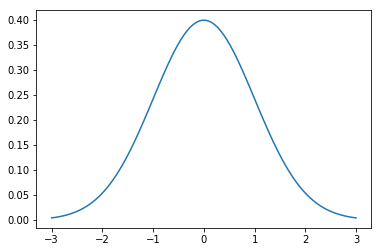

In [46]:
plt.plot(x_inter, stats.norm.pdf(x_inter, mu, sigma))
plt.show()